# Red Wine Qualtiy

Configuring Kaggle API

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"janvichoudhary","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009

  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 46.0MB/s]


In [ ]:
!unzip 'red-wine-quality-cortez-et-al-2009.zip' -d redwine

Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: redwine/winequality-red.csv  


Importing libraries.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import imblearn
from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings("ignore")
print(os.listdir("/content"))

['.config', 'red-wine-quality-cortez-et-al-2009.zip', 'redwine', 'sample_data']


In [ ]:
df = pd.read_csv("/content/redwine/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1599
Variables: 12
cat_cols: 1
num_cols: 11
cat_but_car: 0
num_but_cat: 1


In [ ]:
df.info

<bound method DataFrame.info of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067

In [ ]:
print("Quality Points:",df['quality'].unique())

Quality Points: [5 6 7 4 8 3]


In [ ]:
print(df['quality'].value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


<Axes: ylabel='quality'>

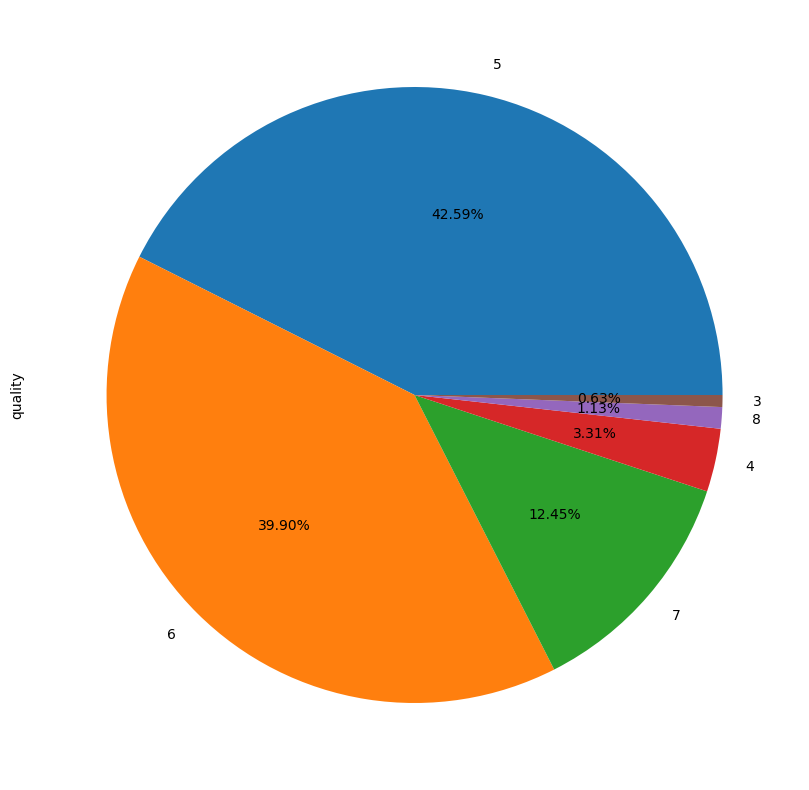

In [ ]:
plt.figure(1, figsize=(10,10))
df['quality'].value_counts().plot.pie(autopct="%1.2f%%")

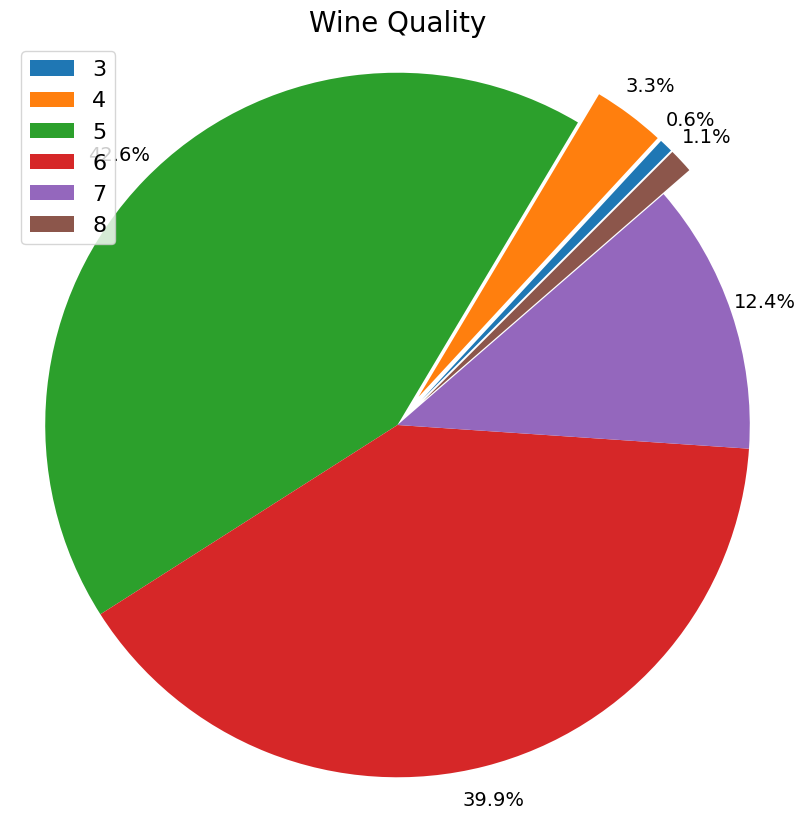

In [ ]:
quality = df["quality"].value_counts().sort_index(ascending=True)
explode_list = [0.1, 0.1, 0, 0, 0, 0.1]
ax = quality.plot(kind='pie',
             figsize = (10,10),
             autopct='%1.1f%%',
             startangle=45,
             labels=None,
             pctdistance=1.1,
             explode=explode_list,
             textprops={'fontsize': 14})
ax.patch.set_facecolor('white')
plt.title('Wine Quality', size = 20)
ax.set(ylabel=None)
plt.axis('equal')
plt.legend(labels=quality.index, loc="upper left", fontsize=16);

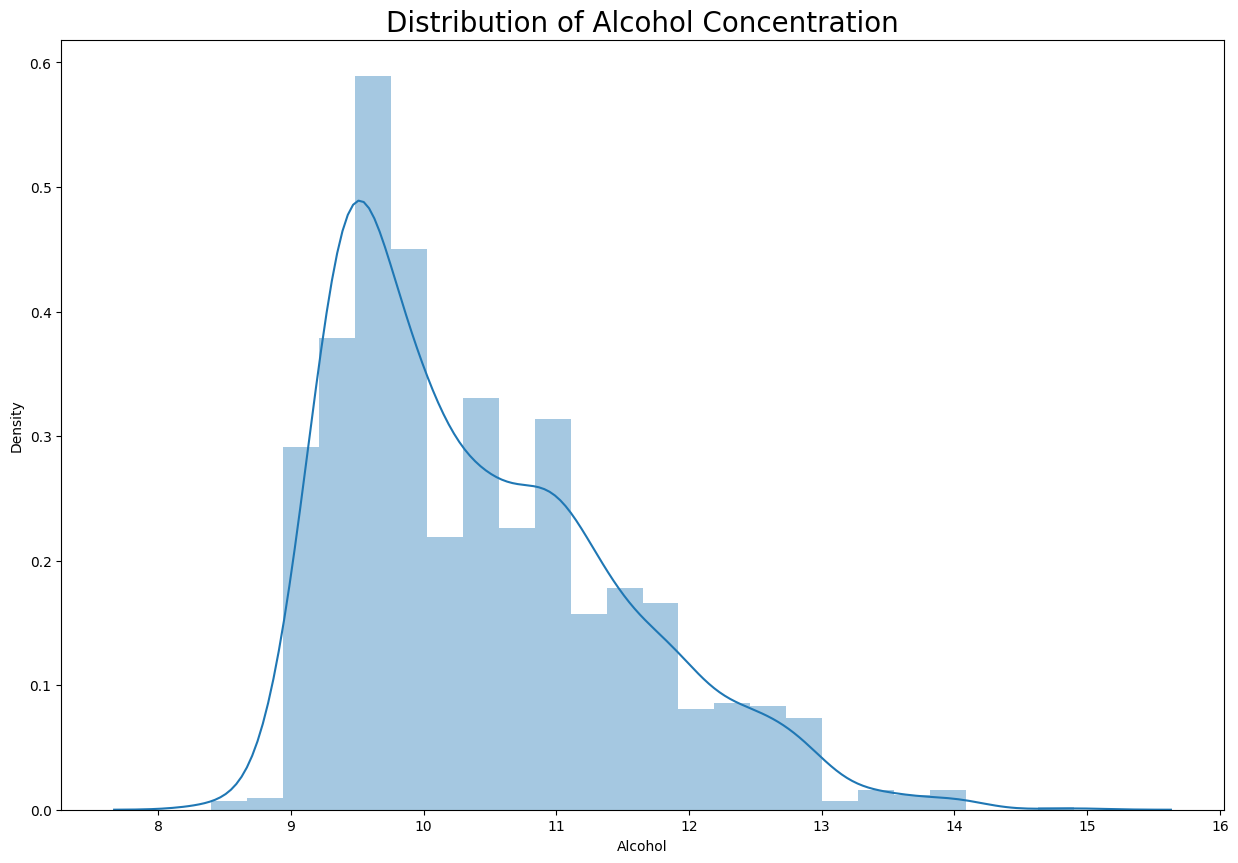

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.distplot(df['alcohol'])
ax.set_title('Distribution of Alcohol Concentration', size=20)
ax.set(ylabel='Density', xlabel='Alcohol');

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


Defining all the features and exploring them.

In [ ]:
features = ['residual sugar', 'total sulfur dioxide', 'sulphates',
                   'alcohol', 'volatile acidity', 'quality']
df_features = df[features]

In [ ]:
case_1 = (df_features['quality']==3)|(df_features['quality']==4)
case_2 = (df_features['quality']==5)|(df_features['quality']==6)
case_3 = (df_features['quality']==7)|(df_features['quality']==8)
level_34 = round(df_features[case_1].describe(),2)
level_56 = round(df_features[case_2].describe(),2)
level_78 = round(df_features[case_3].describe(),2)

In [ ]:
level_all = pd.concat([level_34,level_56, level_78],
                    axis=1,
                    keys=['3,4','5,6','7,8',])
level_all.T

count   mean    std   min    25%    50%    75%  \
3,4 residual sugar          63.0   2.68   1.72  1.20   1.90   2.10   2.95   
    total sulfur dioxide    63.0  34.44  26.40  7.00  13.50  26.00  48.00   
    sulphates               63.0   0.59   0.22  0.33   0.50   0.56   0.60   
    alcohol                 63.0  10.22   0.92  8.40   9.60  10.00  11.00   
    volatile acidity        63.0   0.72   0.25  0.23   0.56   0.68   0.88   
    quality                 63.0   3.84   0.37  3.00   4.00   4.00   4.00   
5,6 residual sugar        1319.0   2.50   1.40  0.90   1.90   2.20   2.60   
    total sulfur dioxide  1319.0  48.95  32.71  6.00  24.00  40.00  65.00   
    sulphates             1319.0   0.65   0.17  0.37   0.54   0.61   0.70   
    alcohol               1319.0  10.25   0.97  8.40   9.50  10.00  10.90   
    volatile acidity      1319.0   0.54   0.17  0.16   0.41   0.54   0.64   
    quality               1319.0   5.48   0.50  5.00   5.00   5.00   6.00   
7,8 residual sugar         217.0   2.71   1.36  1.20   2.00   2.30   2.70   
    total sulfur dioxide   217.0  34.89  32.57  7.00  17.00  27.00  43.00   
    sulphates              217.0   0.74   0.13  0.39   0.65   0.74   0.82   
    alcohol                217.0  11.52   1.00  9.20  10.80  11.60  12.20   
    volatile acidity       217.0   0.41   0.14  0.12   0.30   0.37   0.49   
    quality                217.0   7.08   0.28  7.00   7.00   7.00   7.00   

                             max  
3,4 residual sugar         12.90  
    total sulfur dioxide  119.00  
    sulphates               2.00  
    alcohol                13.10  
    volatile acidity        1.58  
    quality                 4.00  
5,6 residual sugar         15.50  
    total sulfur dioxide  165.00  
    sulphates               1.98  
    alcohol                14.90  
    volatile acidity        1.33  
    quality                 6.00  
7,8 residual sugar          8.90  
    total sulfur dioxide  289.00  
    sulphates               1.36  
    alcohol                14.00  
    volatile acidity        0.92  
    quality                 8.00

Model Suuccess rates

In [ ]:
def get_models():
    models=[]
    models.append(("LR",LogisticRegression()))
    models.append(("NB",GaussianNB()))
    models.append(("KNN",KNeighborsClassifier()))
    models.append(("DT",DecisionTreeClassifier()))
    models.append(("SVM rbf",SVC()))
    models.append(("SVM linear",SVC(kernel='linear')))
    models.append(('LDA', LinearDiscriminantAnalysis()))

    return models

def cross_validation_scores_for_various_ml_models(X_cv, y_cv):
    print("success rates".upper())
    models=get_models()


    results=[]
    names= []

    for name, model in models:
        kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=22)
        cv_result=cross_val_score(model,X_cv, y_cv, cv=kfold,scoring="accuracy")
        names.append(name)
        results.append(cv_result)
        print("{} success rate:{:0.2f}".format(name, cv_result.mean()))

df_temp = df.copy(deep=True)
X = df.drop('quality', axis=1)
y = df['quality']

X=StandardScaler().fit_transform(X)
cross_validation_scores_for_various_ml_models(X, y)

SUCCESS RATES
LR success rate:0.60
NB success rate:0.55
KNN success rate:0.58
DT success rate:0.62
SVM rbf success rate:0.62
SVM linear success rate:0.58
LDA success rate:0.59


In [ ]:
df_temp = df.copy(deep=True)
X = df.drop('quality', axis=1)
y = df['quality']

X=StandardScaler().fit_transform(X)
cross_validation_scores_for_various_ml_models(X, y)

SUCCESS RATES
LR success rate:0.60
NB success rate:0.55
KNN success rate:0.58
DT success rate:0.62
SVM rbf success rate:0.62
SVM linear success rate:0.58
LDA success rate:0.59
